# Continuos Regression with *KQM*

### Concept

We will set `output_dim = 2` so that the model would predict a $2-\dim$ vector: $[cos^2\theta, sin^2\theta]$, and we will actually do the inference over $\theta$. Therefore, the range of the output variable must be within $[0, \pi/2]$.

### Import libraries

In [66]:
import re

In [67]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.layers import Input, Dense, Dropout, Activation
from keras.models import Model
from keras import optimizers
from keras import losses
import concurrent.futures
from itertools import product
from keras.layers import Input, Dense, Reshape
import kqm
import itertools
print("Tensorflow version:",tf.__version__)

Tensorflow version: 2.15.0


In [68]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Check GPU

In [69]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov 10 15:54:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A2000 8GB Lap...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8               3W /  40W |   6499MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Loading Dataset

## Boston

In [70]:
data = pd.read_csv('/home/santiagotoco/Documents/Quantum_Regression/datasets/wpbc_all', header = None, sep = ' ')
X = data.to_numpy()
y = X[:,-1].reshape(-1, 1)
X = X[:,0:-1]

## 70% - 30% Hold Out and MinMax Scaling for `y` 

In [71]:
from sklearn.model_selection import train_test_split

# Split data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

#scaler_x = StandardScaler()
#scaler_x.fit(X_train)
#X_train = scaler_x.transform(X_train)
#X_test = scaler_x.transform(X_test)

scaler = MinMaxScaler(feature_range=(0.2, np.pi/2-0.2))
scaler.fit(y_train)
y_train = scaler.transform(y_train)
#y_test = scaler.transform(y_test))
y_train = np.asarray(y_train).reshape(-1)
y_test = np.asarray(y_test).reshape(-1)

print(f"Training features size: {X_train.shape}")
print(f"Training labels size: {y_train.shape}")

Training set size: (135, 32)
Test set size: (59, 32)
Training features size: (135, 32)
Training labels size: (135,)


## Defining KQM-Model

In [72]:
n_comp=32

In [73]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(X_train.shape[1],),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

## Training and Test

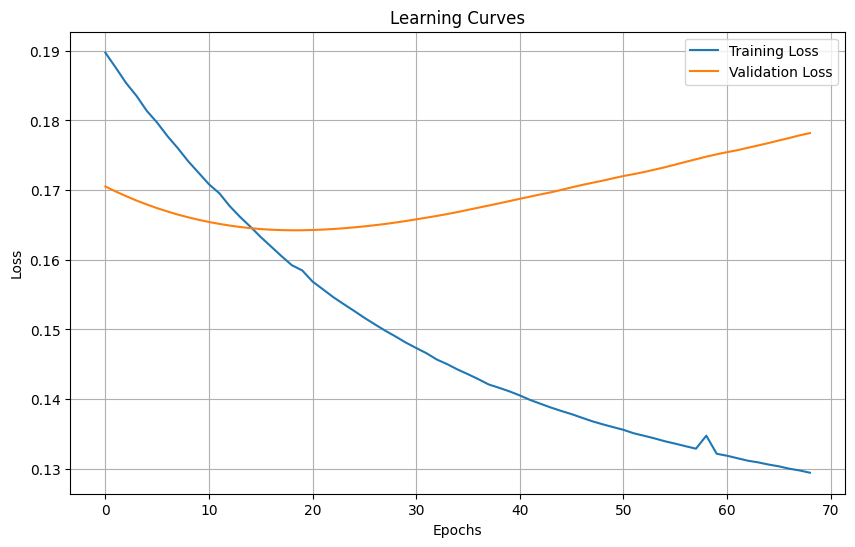

MAE = 1.1555367041442355
MSE = 1.8104985744870044
R^2 = -0.007408174199051043


In [74]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=50,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 0.001
encoding_dim = X_train.shape[1]
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

kqm_model.kqm_class_encoded.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss=losses.mse)

np.random.seed(42)
indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
selected_samples = X_train[indices]
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
#kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))

history = kqm_model.kqm_class_encoded.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
print('MAE =',mean_absolute_error(y_test, y_pred))
print('MSE =',mean_squared_error(y_test, y_pred))
print('R^2 =',r2_score(y_test, y_pred))

# Initializing weights `c_y`

ok


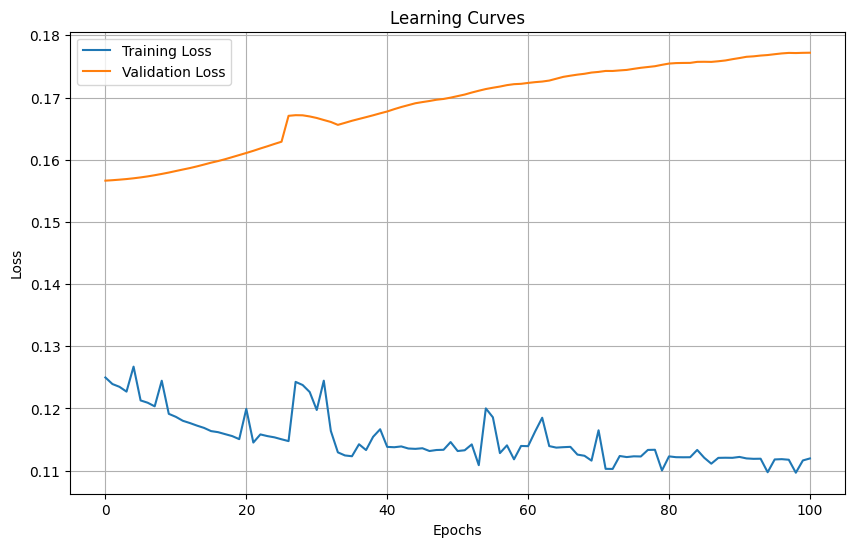

MAE = 1.1507868847604525
MSE = 1.797667511106368
R^2 = -0.00026863909227414773


In [75]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=100,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 0.001
encoding_dim = X_train.shape[1]
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

kqm_model.kqm_class_encoded.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss=losses.mse)

np.random.seed(42)
indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
selected_samples = X_train[indices]
selected_labels = y_train[indices]
cos_values = np.cos(selected_labels)
sin_values = np.sin(selected_labels)
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
kqm_model.kqm_unit_encoded.c_y.assign(np.column_stack((cos_values, sin_values)))
print('ok')

history = kqm_model.kqm_class_encoded.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
print('MAE =',mean_absolute_error(y_test, y_pred))
print('MSE =',mean_squared_error(y_test, y_pred))
print('R^2 =',r2_score(y_test, y_pred))

In [76]:
y_pred

array([2.632142, 2.632142, 2.632142, 2.632142, 2.632142, 2.632142,
       2.632142, 2.632142, 2.632142, 2.632142, 2.632142, 2.632142,
       2.632142, 2.632142, 2.632142, 2.632142, 2.632142, 2.632142,
       2.632142, 2.632142, 2.632142, 2.632142, 2.632142, 2.632142,
       2.632142, 2.632142, 2.632142, 2.632142, 2.632142, 2.632142,
       2.632142, 2.632142, 2.632142, 2.632142, 2.632142, 2.632142,
       2.632142, 2.632142, 2.632142, 2.632142, 2.632142, 2.632142,
       2.632142, 2.632142, 2.632142, 2.632142, 2.632142, 2.632142,
       2.632142, 2.632142, 2.632142, 2.632142, 2.632142, 2.632142,
       2.632142, 2.632142, 2.632142, 2.632142, 2.632142], dtype=float32)

In [77]:
y_test

array([1., 1., 2., 3., 2., 2., 2., 1., 4., 4., 4., 1., 3., 1., 2., 5., 2.,
       4., 5., 5., 5., 1., 2., 2., 2., 4., 2., 3., 1., 4., 5., 3., 1., 3.,
       5., 3., 1., 3., 3., 1., 1., 5., 3., 3., 2., 3., 1., 5., 1., 2., 4.,
       2., 3., 3., 1., 1., 2., 2., 2.])

# Hyper-parameter exploration

We are going to explore:
```
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
```

In [78]:
# Defining hyperparams to explore
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']

# Some fixed hyper-params
encoding_dim = X_train.shape[1]
num_hidden_layer = 1
n_comp=32

# For saving:
best_model = None
best_hyperparameters = None

In [79]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(X_train.shape[1],),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

In [80]:
best_MSE = 1000

for lr, kernel in itertools.product(learning_rates, kernels):
    print(f"Running experiment with learning_rate={lr} and kernel={kernel}")

    stoppping_a = EarlyStopping(
                            monitor="val_loss",
                            min_delta=0,
                            patience=50,
                            verbose=0,
                            mode="min",
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0,
                        )
    
    kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
    kqm_model.encoder.trainable = True
    
    kqm_model.kqm_class_encoded.compile(
              optimizer=optimizers.Adam(learning_rate=lr),
              loss=losses.mse)
    
    np.random.seed(42)
    indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
    selected_samples = X_train[indices]
    kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
    #kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
    
    kqm_model.kqm_class_encoded.fit(X_train, y_train,
              validation_split = 0.2,
              epochs=200,
              batch_size=32,
              verbose=0,
              callbacks=[stoppping_a])
    
    y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
    print('MAE =',mean_absolute_error(y_test, y_pred))
    print('MSE =',mean_squared_error(y_test, y_pred))
    print('R^2 =',r2_score(y_test, y_pred))

    if mean_squared_error(y_test, y_pred) < best_MSE:
        best_MSE = mean_squared_error(y_test, y_pred)
        best_model = kqm_model
        best_hyperparameters = (lr, kernel)
        print("New best model")

print("Best hyper-parameters:", best_hyperparameters)

Running experiment with learning_rate=1e-05 and kernel=rbf
MAE = 1.1679386688491045
MSE = 1.9262747367272484
R^2 = -0.07182902150696169
New best model
Running experiment with learning_rate=1e-05 and kernel=cos
MAE = 1.1675740338988223
MSE = 1.921185401038128
R^2 = -0.0689971836658767
New best model
Running experiment with learning_rate=5e-05 and kernel=rbf
MAE = 1.1621734409008997
MSE = 1.8576555497929301
R^2 = -0.033647533380625205
New best model
Running experiment with learning_rate=5e-05 and kernel=cos
MAE = 1.1592794353679075
MSE = 1.8329130898688102
R^2 = -0.019880189551363392
New best model
Running experiment with learning_rate=0.0001 and kernel=rbf
MAE = 1.1556424650095276
MSE = 1.8109828968255648
R^2 = -0.00767766365885425
New best model
Running experiment with learning_rate=0.0001 and kernel=cos
MAE = 1.1544143224166612
MSE = 1.8058811998703046
R^2 = -0.004838947689982609
New best model
Running experiment with learning_rate=0.0005 and kernel=rbf
MAE = 1.155241170171964
MSE = 1

## Adding an Encoder

We are going to explore:
```
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
encoding_dim = [6, 8, 16]
num_hidden_layer = [1,2]
```

In [81]:
# Defining hyperparams to explore
learning_rates = [1e-3, 5e-3, 1e-2, 1e-1, 5e-1, 1, 2]
kernels = ['rbf', 'cos']
encoding_dim = [16, 32, 64, 128, 256]
num_hidden_layers = [1,2]

# Some fixed hyper-params

n_comp=32

# For saving:
best_model = None
best_hyperparameters = None

In [82]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(X_train.shape[1],),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

In [83]:
best_MSE = 1000

for lr, kernel, encoding_dim, num_hidden_layer in itertools.product(learning_rates, kernels, encoding_dim, num_hidden_layers):
    print(f"Running experiment with learning_rate={lr}, kernel={kernel}, encoding_dim={encoding_dim} and num_h_l={num_hidden_layer}")

    stoppping_a = EarlyStopping(
                            monitor="val_loss",
                            min_delta=0,
                            patience=50,
                            verbose=0,
                            mode="min",
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0,
                        )
    
    kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=True)
    kqm_model.encoder.trainable = True
    
    kqm_model.kqm_class_encoded.compile(
              optimizer=optimizers.Adam(learning_rate=lr),
              loss=losses.mse)
    
    np.random.seed(42)
    indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
    selected_samples = X_train[indices]
    kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
    #kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
    
    kqm_model.kqm_class_encoded.fit(X_train, y_train,
              validation_split = 0.2,
              epochs=200,
              batch_size=32,
              verbose=0,
              callbacks=[stoppping_a])
    
    y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
    print('MAE =',mean_absolute_error(y_test, y_pred))
    print('MSE =',mean_squared_error(y_test, y_pred))
    print('R^2 =',r2_score(y_test, y_pred))

    if mean_squared_error(y_test, y_pred) < best_MSE:
        best_MSE = mean_squared_error(y_test, y_pred)
        best_model = kqm_model
        best_hyperparameters = (lr, kernel, encoding_dim, num_hidden_layer)
        print("New best model")

print("Best hyper-parameters:", best_hyperparameters)

Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 1.1586815219814495
MSE = 1.8348756005866351
R^2 = -0.02097218120877198
New best model
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 1.1573514615075062
MSE = 1.8193619024655971
R^2 = -0.012339958836755871
New best model
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 1.154472221762447
MSE = 1.8061056838418215
R^2 = -0.004963856370425512
New best model
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 1.1545087644609355
MSE = 1.8063473406861725
R^2 = -0.005098320480908969
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 1.154833300639007
MSE = 1.808766723232957
R^2 = -0.006444527425499391
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 1.1547680588091833
MSE = 1.80723858907317

In [84]:
y_test.max(), y_test.mean(), y_test.min()

(5.0, 2.610169491525424, 1.0)

# Analysis

In [85]:
texto = """
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 1.1528661816807118
MSE = 1.8011367774210942
R^2 = -0.002199028485107002
New best model
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 1.1101752196328114
MSE = 1.7498529393562305
R^2 = 0.026336623737365894
New best model
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 1.1549860905792753
MSE = 1.808116874194916
R^2 = -0.006082934634351611
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 1.154642743579412
MSE = 1.8067504305141846
R^2 = -0.005322610073509759
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 1.1548521316657632
MSE = 1.8075728990241036
R^2 = -0.005780252797779051
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 1.1547055891004658
MSE = 1.8069937233048938
R^2 = -0.0054579844668056765
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=128 and num_h_l=1
MAE = 1.154221082137803
MSE = 1.805197077677079
R^2 = -0.004458284429973203
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=128 and num_h_l=2
MAE = 1.1547665191909013
MSE = 1.807232517867999
R^2 = -0.005590855930068139
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=256 and num_h_l=1
MAE = 1.1543568716210835
MSE = 1.8056822966069805
R^2 = -0.004728272776358677
Running experiment with learning_rate=0.001, kernel=rbf, encoding_dim=256 and num_h_l=2
MAE = 1.1545218289908716
MSE = 1.8062909298587482
R^2 = -0.005066932039370808
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 1.0813631930593717
MSE = 1.6418571684828274
R^2 = 0.08642826031190487
New best model
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 1.1492654388233767
MSE = 1.7896378071312278
R^2 = 0.004199295616399534
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 1.2508833509380535
MSE = 2.4366008517243944
R^2 = -0.3557876542283598
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 1.1030262365179546
MSE = 1.7194782133722475
R^2 = 0.043237905890538
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 1.0522025177034282
MSE = 1.662535011480427
R^2 = 0.07492257433450011
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 1.1275928586216297
MSE = 1.7516248652880828
R^2 = 0.0253506783779065
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=128 and num_h_l=1
MAE = 1.1339191582243322
MSE = 1.7726504321228402
R^2 = 0.013651509875382328
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=128 and num_h_l=2
MAE = 1.093874515113184
MSE = 1.7255131022280892
R^2 = 0.039879937842714375
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=256 and num_h_l=1
MAE = 1.0720181222689353
MSE = 1.668958792931589
R^2 = 0.07134821640107702
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=256 and num_h_l=2
MAE = 1.0674321408999168
MSE = 1.7251946972383132
R^2 = 0.040057106603809345
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 1.1553508831282793
MSE = 1.8096685803228185
R^2 = -0.0069463440063510795
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 1.287258109803927
MSE = 2.4769295381256335
R^2 = -0.37822757708045596
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 1.15659110020783
MSE = 1.8157139556384572
R^2 = -0.01031014699128363
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 1.156553846294597
MSE = 1.8155150298468146
R^2 = -0.010199459542321376
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 1.1562531600564212
MSE = 1.8139487489141413
R^2 = -0.00932794037246265
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 1.1557792970689678
MSE = 1.8116223457846876
R^2 = -0.008033469577445329
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=128 and num_h_l=1
MAE = 1.1554103827072402
MSE = 1.8099314360182317
R^2 = -0.007092603705157519
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=128 and num_h_l=2
MAE = 1.1554347741401803
MSE = 1.8100399832907033
R^2 = -0.0071530022114671965
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=256 and num_h_l=1
MAE = 1.1556356276495983
MSE = 1.8109513241457271
R^2 = -0.007660095804232103
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=256 and num_h_l=2
MAE = 1.1554430905034987
MSE = 1.810077098154613
R^2 = -0.007173653880468089
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 1.1520571547039484
MSE = 1.7988136821785454
R^2 = -0.0009063982838104501
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 1.0739586676581432
MSE = 1.8131227426886631
R^2 = -0.008868329171872968
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 1.016772383350437
MSE = 1.479841766350282
R^2 = 0.1765778151110402
New best model
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 1.2432578478829335
MSE = 2.1570800607534575
R^2 = -0.2002550657741029
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 1.093291476621466
MSE = 1.6800719926328977
R^2 = 0.06516454501996205
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 1.071111238608926
MSE = 1.6906244724801587
R^2 = 0.05929287264970695
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=128 and num_h_l=1
MAE = 1.1609301021543599
MSE = 1.9758970229914088
R^2 = -0.09944014338764307
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=128 and num_h_l=2
MAE = 1.060920274863809
MSE = 1.6649249327899964
R^2 = 0.07359276038331541
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=256 and num_h_l=1
MAE = 1.1587826639918957
MSE = 1.9238335807370295
R^2 = -0.07047069925601024
Running experiment with learning_rate=0.005, kernel=cos, encoding_dim=256 and num_h_l=2
MAE = 1.0811424780700167
MSE = 1.619990091833869
R^2 = 0.09859566661226049
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 1.1528053243281478
MSE = 1.8009877275378112
R^2 = -0.0021160932799106913
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 1.132060170173645
MSE = 1.8410501530176029
R^2 = -0.024407861677473885
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 1.1530779095019323
MSE = 1.8016776568757735
R^2 = -0.002499987785257174
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 1.1517131045713263
MSE = 1.7987998110033645
R^2 = -0.0008986800036303588
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 1.1517438363220731
MSE = 1.7988487551109462
R^2 = -0.0009259137693740094
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 1.1507823386434781
MSE = 1.797663590097314
R^2 = -0.00026645734155206213
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=128 and num_h_l=1
MAE = 1.1506022033044847
MSE = 1.797521091224873
R^2 = -0.00018716728800871607
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=128 and num_h_l=2
MAE = 1.1514384463682013
MSE = 1.7983948259929734
R^2 = -0.0006733358825992131
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=256 and num_h_l=1
MAE = 1.1511789055193884
MSE = 1.7980657569791618
R^2 = -0.0004902333830663075
Running experiment with learning_rate=0.01, kernel=rbf, encoding_dim=256 and num_h_l=2
MAE = 1.1504294629824363
MSE = 1.7974080186663153
R^2 = -0.00012425079562738972
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 1.1556408223459276
MSE = 2.069411567923822
R^2 = -0.15147405178114215
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 1.0870651006698608
MSE = 1.7109168879685024
R^2 = 0.048001648494508053
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 1.0879400059328241
MSE = 1.7683995463677686
R^2 = 0.016016812514993095
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 1.141726530204385
MSE = 1.8633435059444798
R^2 = -0.03681245911009201
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 1.0793847552800582
MSE = 1.7261012009244427
R^2 = 0.03955270453676696
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 1.1503953570026462
MSE = 1.797156101335459
R^2 = 1.5922514588595504e-05
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=128 and num_h_l=1
MAE = 1.0823257252321405
MSE = 1.646185064921472
R^2 = 0.08402010693867568
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=128 and num_h_l=2
MAE = 1.0808572385270716
MSE = 1.6884928253676603
R^2 = 0.06047897616610831
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=256 and num_h_l=1
MAE = 1.0348556910530995
MSE = 1.626458467429806
R^2 = 0.09499649534476418
Running experiment with learning_rate=0.01, kernel=cos, encoding_dim=256 and num_h_l=2
MAE = 1.1300098007008181
MSE = 1.8117198636886718
R^2 = -0.0080877310582268
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 1.0500333672862943
MSE = 1.5988797174022582
R^2 = 0.11034202425235584
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 1.1394461534791074
MSE = 1.8376105670427678
R^2 = -0.02249398719243545
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 1.1393497030613786
MSE = 1.8383769365925133
R^2 = -0.022920415006160377
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 1.1453883405459129
MSE = 1.8042741539670126
R^2 = -0.003944745837463515
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 1.1420806828191725
MSE = 1.8194600992660863
R^2 = -0.012394598073089291
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 1.1461862749972587
MSE = 1.8018778004770433
R^2 = -0.002611352854953397
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=128 and num_h_l=1
MAE = 1.1462852348715573
MSE = 1.8016149336472154
R^2 = -0.002465086960671048
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=128 and num_h_l=2
MAE = 1.1561304148981126
MSE = 1.8133294692530983
R^2 = -0.00898335717232035
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=256 and num_h_l=1
MAE = 1.146981227195869
MSE = 1.7999801678874001
R^2 = -0.0015554610639449962
Running experiment with learning_rate=0.1, kernel=rbf, encoding_dim=256 and num_h_l=2
MAE = 1.143544968912157
MSE = 1.8116933458318147
R^2 = -0.008072975837683405
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 1.1649500495296414
MSE = 1.9447854347248732
R^2 = -0.08212885202642028
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 1.1941674927533683
MSE = 1.987298770929746
R^2 = -0.10578437046138855
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 1.05172635741153
MSE = 1.654692347171216
R^2 = 0.07928643534159141
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 1.1513309519169694
MSE = 1.7982522133979757
R^2 = -0.0005939825508878283
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 1.0602459139743095
MSE = 1.6464125926962243
R^2 = 0.08389350460748768
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 1.106493941808151
MSE = 1.6969248415064562
R^2 = 0.05578718457736975
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=128 and num_h_l=1
MAE = 1.0201824640823622
MSE = 1.5693067912783487
R^2 = 0.12679716425192888
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=128 and num_h_l=2
MAE = 1.1231614048198117
MSE = 1.8720781171480674
R^2 = -0.04167262240927494
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=256 and num_h_l=1
MAE = 1.134184914120173
MSE = 1.8367048419943248
R^2 = -0.021990018379514975
Running experiment with learning_rate=0.1, kernel=cos, encoding_dim=256 and num_h_l=2
MAE = 1.0131904917248225
MSE = 1.5281077347342518
R^2 = 0.14972138353421816
Running experiment with learning_rate=0.5, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 1.029969263884981
MSE = 1.5460077352981314
R^2 = 0.13976136084194435
Running experiment with learning_rate=0.5, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 1.1427650613299871
MSE = 1.8156236281091862
R^2 = -0.010259886420728614
Running experiment with learning_rate=0.5, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 1.1488832578820698
MSE = 1.803126807948649
R^2 = -0.00330633287551918
Running experiment with learning_rate=0.5, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 1.1452416525048725
MSE = 1.8047682806879013
R^2 = -0.0042196907088531965
Running experiment with learning_rate=0.5, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 1.1573839127007177
MSE = 1.8458424571541192
R^2 = -0.027074423490007993
Running experiment with learning_rate=0.5, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 1.155371055764667
MSE = 1.809757391630516
R^2 = -0.006995760912056781
Running experiment with learning_rate=0.5, kernel=rbf, encoding_dim=128 and num_h_l=1
MAE = 1.1554113404225494
MSE = 1.8099356893828364
R^2 = -0.007094970387093058
Running experiment with learning_rate=0.5, kernel=rbf, encoding_dim=128 and num_h_l=2
MAE = 1.1558050826444464
MSE = 1.8117444697821001
R^2 = -0.008101422524215307
Running experiment with learning_rate=0.5, kernel=rbf, encoding_dim=256 and num_h_l=1
MAE = 1.1438253249152233
MSE = 1.8103954842177437
R^2 = -0.0073508121102887625
Running experiment with learning_rate=0.5, kernel=rbf, encoding_dim=256 and num_h_l=2
MAE = 1.1486761408337092
MSE = 1.7975664786847487
R^2 = -0.0002124220430963497
Running experiment with learning_rate=0.5, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 1.1329813084359897
MSE = 1.8195544085318753
R^2 = -0.012447074184696039
Running experiment with learning_rate=0.5, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 1.1368059707900224
MSE = 1.8569925623162247
R^2 = -0.03327863002282272
Running experiment with learning_rate=0.5, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 1.0381412102004228
MSE = 1.642132989520729
R^2 = 0.08627478636162744
Running experiment with learning_rate=0.5, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 1.1471161074557548
MSE = 1.7997067029850335
R^2 = -0.0014032981283411683
Running experiment with learning_rate=0.5, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 1.1268642958948167
MSE = 1.769336440115197
R^2 = 0.015495500632832226
Running experiment with learning_rate=0.5, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 1.153492272910425
MSE = 1.8028365302696567
R^2 = -0.003144814876706592
Running experiment with learning_rate=0.5, kernel=cos, encoding_dim=128 and num_h_l=1
MAE = 0.991047152018143
MSE = 1.4898527179703014
R^2 = 0.17100746303474756
Running experiment with learning_rate=0.5, kernel=cos, encoding_dim=128 and num_h_l=2
MAE = 1.146013272010674
MSE = 1.8023551516687724
R^2 = -0.002876963388586562
Running experiment with learning_rate=0.5, kernel=cos, encoding_dim=256 and num_h_l=1
MAE = 1.1124876151650638
MSE = 1.6968250572770873
R^2 = 0.05584270710013717
Running experiment with learning_rate=0.5, kernel=cos, encoding_dim=256 and num_h_l=2
MAE = 1.1421136088290458
MSE = 1.8192672272216008
R^2 = -0.012287279085420932
Running experiment with learning_rate=1, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 1.162416179301375
MSE = 1.8600261995741905
R^2 = -0.03496662415565188
Running experiment with learning_rate=1, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 1.1439127396729032
MSE = 1.81581072934031
R^2 = -0.010363994378775665
Running experiment with learning_rate=1, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 1.155647435430753
MSE = 1.8110058712962198
R^2 = -0.007690447247784782
Running experiment with learning_rate=1, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 1.1590292615405584
MSE = 1.8310674582885083
R^2 = -0.018853232465201097
Running experiment with learning_rate=1, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 1.1515135118516826
MSE = 1.7984992623456526
R^2 = -0.0007314469669466028
Running experiment with learning_rate=1, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 1.1577031531576383
MSE = 1.822146353592912
R^2 = -0.013889299369713504
Running experiment with learning_rate=1, kernel=rbf, encoding_dim=128 and num_h_l=1
MAE = 1.1584666219808288
MSE = 1.8271162800612875
R^2 = -0.016654694835892325
Running experiment with learning_rate=1, kernel=rbf, encoding_dim=128 and num_h_l=2
MAE = 1.1569526680445268
MSE = 1.8177004035998663
R^2 = -0.011415457949350172
Running experiment with learning_rate=1, kernel=rbf, encoding_dim=256 and num_h_l=1
MAE = 1.1665919756485243
MSE = 1.9079445703483058
R^2 = -0.06162964344348665
Running experiment with learning_rate=1, kernel=rbf, encoding_dim=256 and num_h_l=2
MAE = 1.1517295675762629
MSE = 1.7988259395148616
R^2 = -0.0009132185823583772
Running experiment with learning_rate=1, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 1.0932516445547849
MSE = 1.73860406215826
R^2 = 0.03259578958233633
Running experiment with learning_rate=1, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 1.1634728666079246
MSE = 1.8685114375444047
R^2 = -0.03968802974617547
Running experiment with learning_rate=1, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 1.014743386688879
MSE = 1.5535818599820341
R^2 = 0.13554692221907583
Running experiment with learning_rate=1, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 1.1602878813016213
MSE = 1.8408651002589889
R^2 = -0.024304893542445694
Running experiment with learning_rate=1, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 1.0868751154107563
MSE = 1.6445936963223422
R^2 = 0.08490558553419536
Running experiment with learning_rate=1, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 1.1589296955173298
MSE = 1.8303504155450416
R^2 = -0.018454251360660257
Running experiment with learning_rate=1, kernel=cos, encoding_dim=128 and num_h_l=1
MAE = 1.1150084895602728
MSE = 1.7676077257611318
R^2 = 0.016457401954203976
Running experiment with learning_rate=1, kernel=cos, encoding_dim=128 and num_h_l=2
MAE = 1.156341585062318
MSE = 1.8144020971180985
R^2 = -0.009580195023673577
Running experiment with learning_rate=1, kernel=cos, encoding_dim=256 and num_h_l=1
MAE = 1.1010540077241802
MSE = 1.7149582105951118
R^2 = 0.045752952192841256
Running experiment with learning_rate=1, kernel=cos, encoding_dim=256 and num_h_l=2
MAE = 1.069451008812856
MSE = 1.60310360098927
R^2 = 0.10799174631655206
Running experiment with learning_rate=2, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 1.1553591752456407
MSE = 1.809705048790731
R^2 = -0.006966636003922
Running experiment with learning_rate=2, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 1.1439817881180068
MSE = 1.8102802349864502
R^2 = -0.007286684460970916
Running experiment with learning_rate=2, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 1.0862247580188815
MSE = 1.6480989855598447
R^2 = 0.08295515205661441
Running experiment with learning_rate=2, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 1.144848867998285
MSE = 1.8061744169644038
R^2 = -0.005002101255289437
Running experiment with learning_rate=2, kernel=rbf, encoding_dim=64 and num_h_l=1
MAE = 1.0622338521278512
MSE = 1.6229718134482394
R^2 = 0.09693655968457127
Running experiment with learning_rate=2, kernel=rbf, encoding_dim=64 and num_h_l=2
MAE = 1.1568460706937111
MSE = 1.8171042471426093
R^2 = -0.011083741097094535
Running experiment with learning_rate=2, kernel=rbf, encoding_dim=128 and num_h_l=1
MAE = 1.1598252704588032
MSE = 1.8502587480876076
R^2 = -0.029531761843504256
Running experiment with learning_rate=2, kernel=rbf, encoding_dim=128 and num_h_l=2
MAE = 1.1502145468178442
MSE = 1.797299562462851
R^2 = -6.390296246561178e-05
Running experiment with learning_rate=2, kernel=rbf, encoding_dim=256 and num_h_l=1
MAE = 1.1427637278023413
MSE = 1.8156307512634242
R^2 = -0.010263849927746316
Running experiment with learning_rate=2, kernel=rbf, encoding_dim=256 and num_h_l=2
MAE = 1.156256069571285
MSE = 1.8139635695394252
R^2 = -0.009336186951205194
Running experiment with learning_rate=2, kernel=cos, encoding_dim=16 and num_h_l=1
MAE = 1.1346100043442289
MSE = 1.8244360390597154
R^2 = -0.01516333950877069
Running experiment with learning_rate=2, kernel=cos, encoding_dim=16 and num_h_l=2
MAE = 1.0970744601750777
MSE = 1.6935492450397698
R^2 = 0.05766545364714848
Running experiment with learning_rate=2, kernel=cos, encoding_dim=32 and num_h_l=1
MAE = 1.0330299825991613
MSE = 1.5900278615442542
R^2 = 0.11526742550582647
Running experiment with learning_rate=2, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 1.0728497545597917
MSE = 1.6469818027822112
R^2 = 0.08357678141226377
Running experiment with learning_rate=2, kernel=cos, encoding_dim=64 and num_h_l=1
MAE = 1.1391427597757113
MSE = 1.8636009680576602
R^2 = -0.036955717680421385
Running experiment with learning_rate=2, kernel=cos, encoding_dim=64 and num_h_l=2
MAE = 1.1429537797378282
MSE = 1.8146294445599251
R^2 = -0.009706697012963561
Running experiment with learning_rate=2, kernel=cos, encoding_dim=128 and num_h_l=1
MAE = 1.0769276194653268
MSE = 1.7335747391622722
R^2 = 0.035394234810762426
Running experiment with learning_rate=2, kernel=cos, encoding_dim=128 and num_h_l=2
MAE = 1.1490692930706476
MSE = 1.793595243349641
R^2 = 0.0019972758791397816
Running experiment with learning_rate=2, kernel=cos, encoding_dim=256 and num_h_l=1
MAE = 1.154406482890501
MSE = 1.8058631108280458
R^2 = -0.00482888247960811
Running experiment with learning_rate=2, kernel=cos, encoding_dim=256 and num_h_l=2
MAE = 1.1805264767953905
MSE = 2.0621062436737057
R^2 = -0.14740918066307063
"""

In [86]:
# Expresión regular para extraer los datos
pattern = re.compile(
    r"Running experiment with learning_rate=(?P<learning_rate>[\deE\-\+\.]+), "
    r"kernel=(?P<kernel>\w+), "
    r"encoding_dim=(?P<encoding_dim>\d+) and num_h_l=(?P<num_h_l>\d+)\n"
    r"MAE = (?P<MAE>[\d\.\-eE]+)\n"
    r"MSE = (?P<MSE>[\d\.\-eE]+)\n"
    r"R\^2 = (?P<R2>[\d\.\-eE]+)"
)

# Extraer los datos en un diccionario
datos = [m.groupdict() for m in pattern.finditer(texto)]

# Convertir a DataFrame
df_resultados = pd.DataFrame(datos)

# Convertir columnas numéricas al tipo adecuado
df_resultados['learning_rate'] = df_resultados['learning_rate'].astype(float)
df_resultados['encoding_dim'] = df_resultados['encoding_dim'].astype(int)
df_resultados['num_h_l'] = df_resultados['num_h_l'].astype(int)
df_resultados['MAE'] = df_resultados['MAE'].astype(float)
df_resultados['MSE'] = df_resultados['MSE'].astype(float)
df_resultados['R2'] = df_resultados['R2'].astype(float)

# Mostrar el DataFrame
print(df_resultados)

     learning_rate kernel  encoding_dim  num_h_l       MAE       MSE        R2
0            0.001    rbf            16        1  1.152866  1.801137 -0.002199
1            0.001    rbf            16        2  1.110175  1.749853  0.026337
2            0.001    rbf            32        1  1.154986  1.808117 -0.006083
3            0.001    rbf            32        2  1.154643  1.806750 -0.005323
4            0.001    rbf            64        1  1.154852  1.807573 -0.005780
..             ...    ...           ...      ...       ...       ...       ...
135          2.000    cos            64        2  1.142954  1.814629 -0.009707
136          2.000    cos           128        1  1.076928  1.733575  0.035394
137          2.000    cos           128        2  1.149069  1.793595  0.001997
138          2.000    cos           256        1  1.154406  1.805863 -0.004829
139          2.000    cos           256        2  1.180526  2.062106 -0.147409

[140 rows x 7 columns]


In [87]:
df_resultados

,learning_rate,kernel,encoding_dim,num_h_l,MAE,MSE,R2
0,0.001,rbf,16,1,1.152866,1.801137,-0.002199
1,0.001,rbf,16,2,1.110175,1.749853,0.026337
2,0.001,rbf,32,1,1.154986,1.808117,-0.006083
3,0.001,rbf,32,2,1.154643,1.806750,-0.005323
4,0.001,rbf,64,1,1.154852,1.807573,-0.005780
...,...,...,...,...,...,...,...
135,2.000,cos,64,2,1.142954,1.814629,-0.009707
136,2.000,cos,128,1,1.076928,1.733575,0.035394
137,2.000,cos,128,2,1.149069,1.793595,0.001997
138,2.000,cos,256,1,1.154406,1.805863,-0.004829


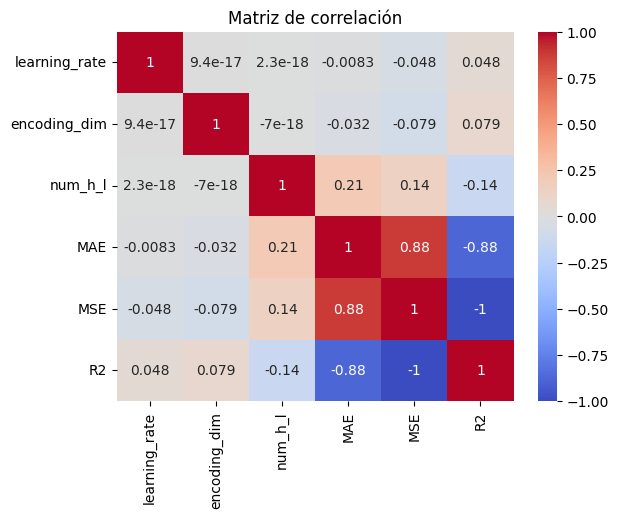

MAE              1.000000
MSE              0.876093
num_h_l          0.207847
learning_rate   -0.008251
encoding_dim    -0.031770
R2              -0.876093
Name: MAE, dtype: float64


In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la correlación entre las columnas
correlation_matrix = df_resultados.corr()

# Visualizar la correlación
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

# Correlación específica con MAE
print(correlation_matrix['MAE'].sort_values(ascending=False))


In [89]:
from sklearn.linear_model import LinearRegression

# Variables independientes y dependiente
X = df_resultados[['learning_rate', 'encoding_dim', 'num_h_l']]
y = df_resultados['MAE']

# Ajustar el modelo
modelo = LinearRegression()
modelo.fit(X, y)

# Coeficientes del modelo
coeficientes = pd.Series(modelo.coef_, index=X.columns)
print("Impacto de las variables en el MAE:")
print(coeficientes.sort_values(ascending=False))


Impacto de las variables en el MAE:
num_h_l          0.019097
encoding_dim    -0.000017
learning_rate   -0.000545
dtype: float64


Importancia de las características según Random Forest:
learning_rate    0.479167
encoding_dim     0.396524
num_h_l          0.124309
dtype: float64


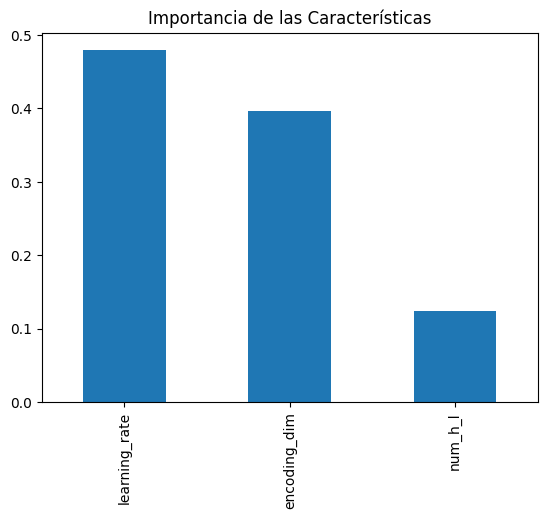

In [90]:
from sklearn.ensemble import RandomForestRegressor

# Crear y ajustar un modelo Random Forest
modelo_rf = RandomForestRegressor(random_state=42)
modelo_rf.fit(X, y)

# Importancia de las características
importancias = pd.Series(modelo_rf.feature_importances_, index=X.columns)
print("Importancia de las características según Random Forest:")
print(importancias.sort_values(ascending=False))

# Visualizar las importancias
importancias.sort_values(ascending=False).plot(kind='bar')
plt.title("Importancia de las Características")
plt.show()


In [91]:
# Crear una nueva interacción manual
df_resultados['dim_hl_interaction'] = df_resultados['encoding_dim'] * df_resultados['num_h_l']

# Evaluar con regresión o modelo de árbol
X = df_resultados[['learning_rate', 'encoding_dim', 'num_h_l', 'dim_hl_interaction']]
modelo_rf.fit(X, y)

# Recalcular las importancias
importancias_interaccion = pd.Series(modelo_rf.feature_importances_, index=X.columns)
print("Importancia con interacciones:")
print(importancias_interaccion.sort_values(ascending=False))


Importancia con interacciones:
learning_rate         0.485876
dim_hl_interaction    0.211378
encoding_dim          0.199486
num_h_l               0.103260
dtype: float64


In [92]:
df_resultados.describe()

,learning_rate,encoding_dim,num_h_l,MAE,MSE,R2,dim_hl_interaction
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,0.516571,99.200000,1.500000,1.129054,1.788057,0.005079,148.800000
std,0.698632,87.597773,0.501795,0.046106,0.128954,0.071753,147.177727
min,0.001000,16.000000,1.000000,0.991047,1.479842,-0.378228,16.000000
25%,0.005000,32.000000,1.000000,1.100059,1.731706,-0.010275,32.000000
50%,0.100000,64.000000,1.500000,1.146633,1.804521,-0.004082,96.000000
75%,1.000000,128.000000,2.000000,1.155381,1.815652,0.036434,256.000000
max,2.000000,256.000000,2.000000,1.287258,2.476930,0.176578,512.000000


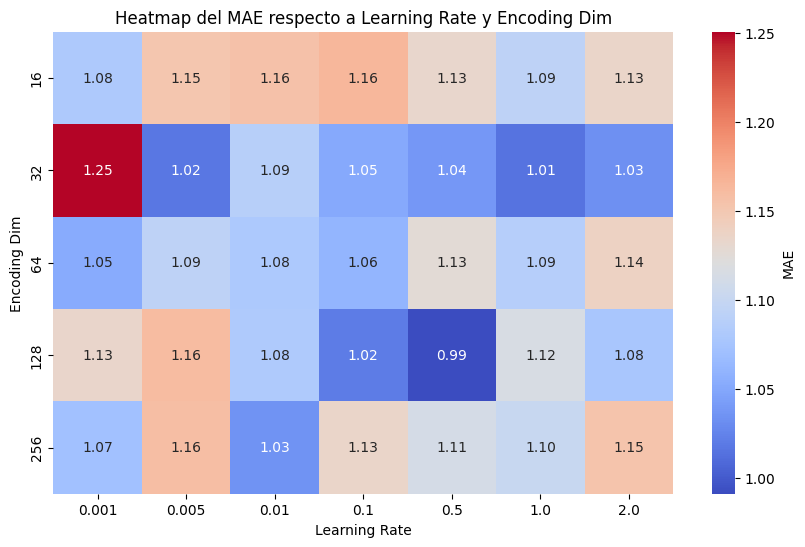

In [93]:
# Ahora puedes ejecutar el código del heatmap
heatmap_data = df_resultados[(df_resultados['kernel'] == 'cos') & (df_resultados['num_h_l'] == 1)].pivot_table(
    index='encoding_dim', 
    columns='learning_rate', 
    values='MAE'
)

# Crear el heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'MAE'})
plt.title("Heatmap del MAE respecto a Learning Rate y Encoding Dim")
plt.xlabel("Learning Rate")
plt.ylabel("Encoding Dim")
plt.show()

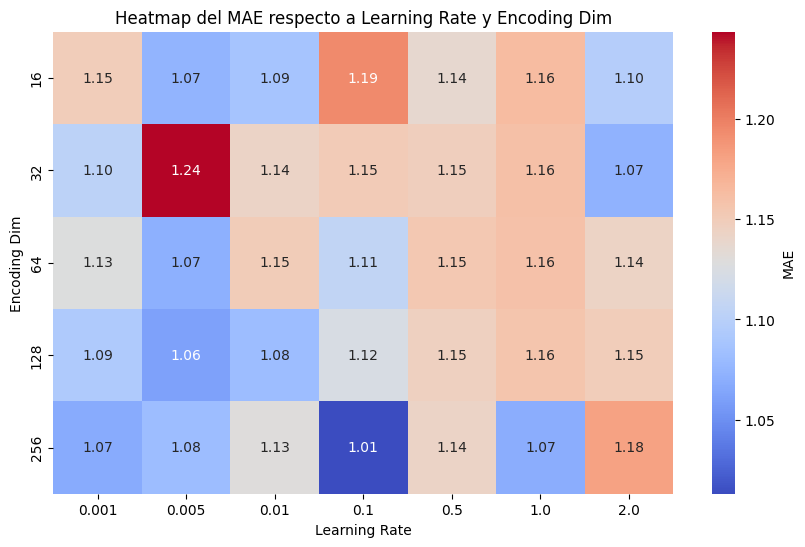

In [94]:
# Ahora puedes ejecutar el código del heatmap
heatmap_data = df_resultados[(df_resultados['kernel'] == 'cos') & (df_resultados['num_h_l'] == 2)].pivot_table(
    index='encoding_dim', 
    columns='learning_rate', 
    values='MAE'
)

# Crear el heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'MAE'})
plt.title("Heatmap del MAE respecto a Learning Rate y Encoding Dim")
plt.xlabel("Learning Rate")
plt.ylabel("Encoding Dim")
plt.show()

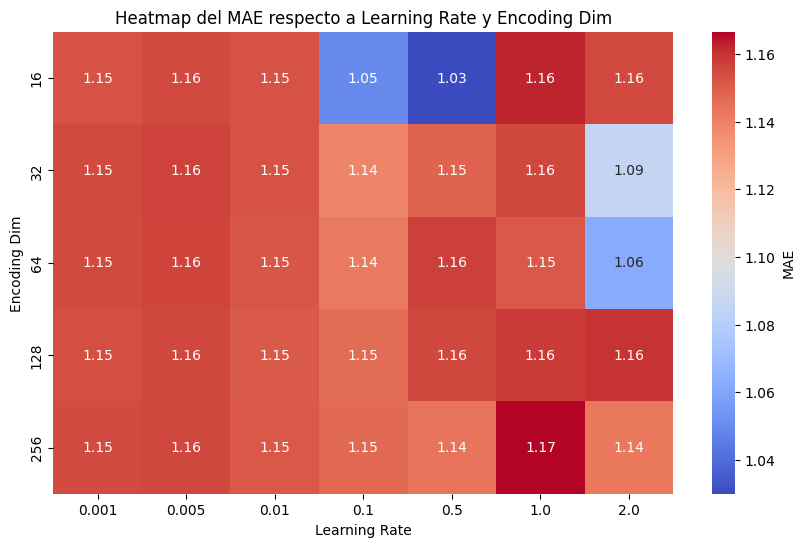

In [95]:
# Ahora puedes ejecutar el código del heatmap
heatmap_data = df_resultados[(df_resultados['kernel'] == 'rbf') & (df_resultados['num_h_l'] == 1)].pivot_table(
    index='encoding_dim', 
    columns='learning_rate', 
    values='MAE'
)

# Crear el heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'MAE'})
plt.title("Heatmap del MAE respecto a Learning Rate y Encoding Dim")
plt.xlabel("Learning Rate")
plt.ylabel("Encoding Dim")
plt.show()

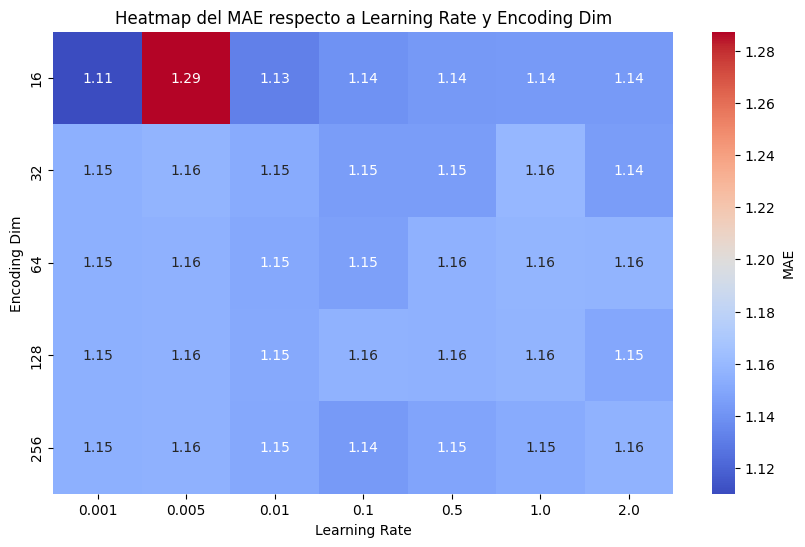

In [96]:
# Ahora puedes ejecutar el código del heatmap
heatmap_data = df_resultados[(df_resultados['kernel'] == 'rbf') & (df_resultados['num_h_l'] == 2)].pivot_table(
    index='encoding_dim', 
    columns='learning_rate', 
    values='MAE'
)

# Crear el heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'MAE'})
plt.title("Heatmap del MAE respecto a Learning Rate y Encoding Dim")
plt.xlabel("Learning Rate")
plt.ylabel("Encoding Dim")
plt.show()